In [22]:
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [23]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

401 - Unauthorized


In [24]:
!unzip cell-images-for-detecting-malaria.zip

Archive:  cell-images-for-detecting-malaria.zip
replace cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
data_dir = '/content/cell_images/cell_images'
classes = os.listdir(data_dir)
print(classes)

['Parasitized', 'Uninfected']


In [ ]:
from torchvision import transforms, datasets, models
transform = transforms.Compose([transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


In [ ]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir,transform)

In [ ]:
from torch.utils.data import random_split
val_size = 3000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(24558, 3000)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)


In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


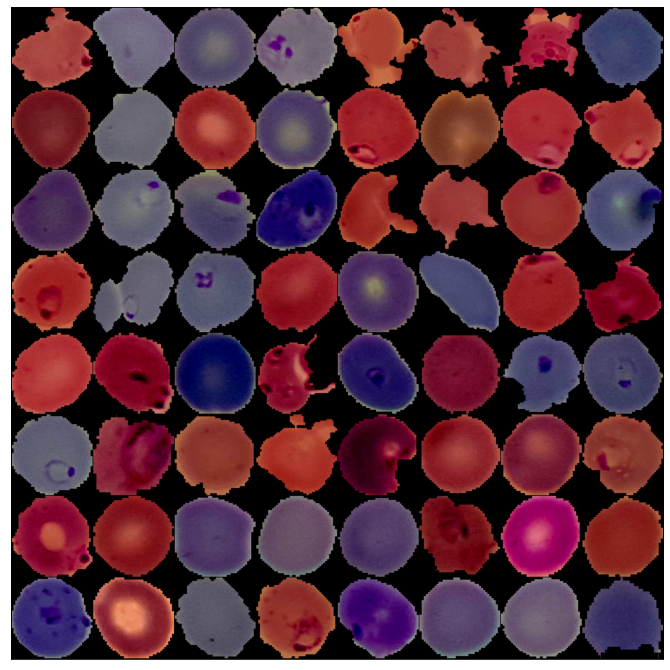

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class MalariaModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(64*28*28, 500),
            nn.ReLU(),
            nn.Linear(500, 2),
            nn.Softmax())
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = MalariaModel()
model

MalariaModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=500, bias=True)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=2, bias=True)
    (13): Softmax(dim=None)
  )
)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(MalariaModel(), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


{'val_acc': 0.499720960855484, 'val_loss': 0.6932825446128845}

In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 3e-4

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [0], train_loss: 0.4712, val_loss: 0.3767, val_acc: 0.9373
Epoch [1], train_loss: 0.3770, val_loss: 0.3700, val_acc: 0.9432
Epoch [2], train_loss: 0.3714, val_loss: 0.3642, val_acc: 0.9498
Epoch [3], train_loss: 0.3671, val_loss: 0.3620, val_acc: 0.9549
Epoch [4], train_loss: 0.3659, val_loss: 0.3569, val_acc: 0.9554
Epoch [5], train_loss: 0.3625, val_loss: 0.3583, val_acc: 0.9547
Epoch [6], train_loss: 0.3631, val_loss: 0.3603, val_acc: 0.9540
Epoch [7], train_loss: 0.3618, val_loss: 0.3552, val_acc: 0.9579
Epoch [8], train_loss: 0.3564, val_loss: 0.3618, val_acc: 0.9524
Epoch [9], train_loss: 0.3548, val_loss: 0.3568, val_acc: 0.9566
Epoch [10], train_loss: 0.3524, val_loss: 0.3592, val_acc: 0.9537
Epoch [11], train_loss: 0.3502, val_loss: 0.3551, val_acc: 0.9574
Epoch [12], train_loss: 0.3474, val_loss: 0.3586, val_acc: 0.9543
Epoch [13], train_loss: 0.3466, val_loss: 0.3538, val_acc: 0.9590
Epoch [14], train_loss: 0.3470, val_loss: 0.3647, val_acc: 0.9481
Epoch [15], train_lo

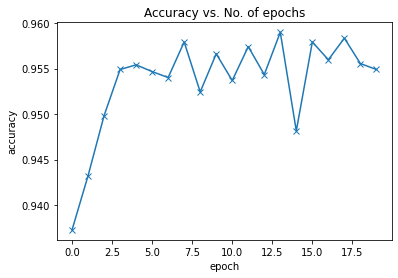

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

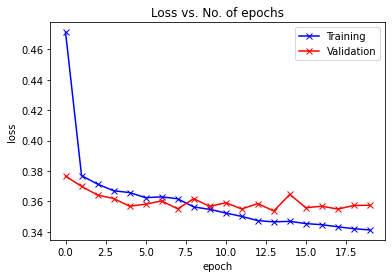

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
torch.save(model, '/content/drive/MyDrive/malariamodel/malaria.pth')

In [ ]:
model = torch.load('/content/drive/MyDrive/malariamodel/malaria.pth')
model.eval()

MalariaModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=500, bias=True)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=2, bias=True)
    (13): Softmax(dim=None)
  )
)